In [18]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import pdb
import numpy as np

# Caricamento dati e left join e arricchimento con Regione
Carico i dati dei customers, e il file Excel con Regione-Provincia-CAP. Trasformo in stringa alcune colonne, e faccio una left join tra Ottobre e Province.
Adesso ho un dataframe iniziale, ma arricchito con la REGIONE del cliente

In [3]:
#Prende File che contiene Provincia-cap-provAbbreviata
prov=pd.read_csv('comune_cap_pr_regione.csv',sep=';')
df = gpd.read_file('Italy_Regions.json')
#Carico il file con le province
prov['REGIONE']=prov['REGIONE'].str.upper()
#Carico il file di Ottobre
Ottobre=pd.read_csv('Ottobre.csv',sep='\t',low_memory=False)

Ottobre['CAP1']=Ottobre['CAP1'].astype(str)
prov['CAP1']=prov['CAP1'].astype(str)
Ottobre['CAP1']=Ottobre['CAP1'].str.split('.')
Ottobre['CAP1']=Ottobre['CAP1'].apply(lambda x: x[0])
Ottobre['COMUNE']=Ottobre['COMUNE'].astype(str)
prov['COMUNE']=prov['COMUNE'].astype(str)
#Nome del comune in LowerCase per fare il join left
prov['COMUNE']=prov['COMUNE'].str.lower()
Ottobre['COMUNE']=Ottobre['COMUNE'].str.lower()
#Join left
result = pd.merge(Ottobre, prov, on='COMUNE', how='left') #Una merge per aggiungere la regione del customer
Ottobre=result
Ottobre=Ottobre[['User_ID','COMUNE','Genere','Utente_Convertito','REGIONE','CAP1_x','Risultato_contatto_Whatsapp']]
#Ottobre.rename(columns={'CAP1_x':'CAP'}, inplace=True)


In [ ]:
pd.to_

Adesso ho un problema: uno stesso utente posso ritrovarlo in vari step (sempre lo stesso customer può essere in step 1,2,3,4). Allora, conto quante volte ogni utente è ripetuto nel dataframe, in modo che io sappia quanti step ha eseguito ogni utente

In [4]:
Ottobre_Num_Step=Ottobre.groupby(['User_ID']).count()

In [6]:
#Remap di Tipo_di_Utilizzo
risposte_conv={'SI':1,'NO':0}
Ottobre['Utente_Convertito']=Ottobre['Utente_Convertito'].map(risposte_conv)
risposte_interaction={'Ha visualizzato e interagito':1,'Ha visualizzato ma non ha interagito':0,'Non ha visualizzato':0}
Ottobre['Risultato_contatto_Whatsapp']=Ottobre['Risultato_contatto_Whatsapp'].map(risposte_interaction)

Calcolo dell'età di ogni customer

In [9]:
Ottobre.head()

,User_ID,COMUNE,Genere,Utente_Convertito,REGIONE,CAP1_x,Risultato_contatto_Whatsapp
0,295199,verona,M,NaN,VENETO,37123,0.0
1,302334,roma,M,1.0,LAZIO,148,1.0
2,302273,san giorgio a cremano,F,1.0,CAMPANIA,80046,1.0
3,302840,parabiago,F,1.0,LOMBARDIA,20015,1.0
4,295144,siracusa,F,NaN,SICILIA,96100,0.0


In [12]:
#Max valori di Progressivo_Follow_Up,Tipo_di_Utilizzo,Utente_Convertito - che 
#con la mappatura di prima sono valori numerici

j=Ottobre.groupby(['User_ID'])['Utente_Convertito','Risultato_contatto_Whatsapp'].max().reset_index()


In [14]:
#Dati anagrafici di ogni customer e left join
Dati_Anagrafici=Ottobre.copy()
Dati_Anagrafici=Ottobre.loc[:,['User_ID','Genere','COMUNE','Eta','REGIONE','Fonte_acquisto','CAP1_x']]
result=pd.merge(Dati_Anagrafici,j,on='User_ID',how='left')
result.head()

,User_ID,Genere,COMUNE,Eta,REGIONE,Fonte_acquisto,CAP1_x,Utente_Convertito,Risultato_contatto_Whatsapp
0,295199,M,verona,NaN,VENETO,NaN,37123,NaN,0.0
1,302334,M,roma,NaN,LAZIO,NaN,148,1.0,1.0
2,302273,F,san giorgio a cremano,NaN,CAMPANIA,NaN,80046,1.0,1.0
3,302840,F,parabiago,NaN,LOMBARDIA,NaN,20015,1.0,1.0
4,295144,F,siracusa,NaN,SICILIA,NaN,96100,NaN,0.0


# Mappa 1: numero di utenti per ogni regione italiana

In [15]:
Num_Users=result.groupby('REGIONE')[['User_ID']].count()
Num_Users.reset_index()

,REGIONE,User_ID
0,ABRUZZO,348
1,BASILICATA,85
2,CALABRIA,284
3,CAMPANIA,1241
4,EMILIA-ROMAGNA,2182
5,FRIULI-VENEZIA GIULIA,82
6,LAZIO,2045
7,LIGURIA,156
8,LOMBARDIA,1998
9,MARCHE,317


In [16]:
df2=df.copy()
df2.set_value(3, 'name', 'trentino-alto adige')
df2.set_value(5, 'name', 'friuli-venezia giulia')
df2['name']=df2['name'].str.upper()
df2 = df2.rename(columns={'name': 'REGIONE'})
Num_Users=Num_Users.reset_index()
df2=pd.merge(df2,Num_Users,on='REGIONE',how='left')
df2 = df2.rename(columns={'User_ID': 'Count_Users'})

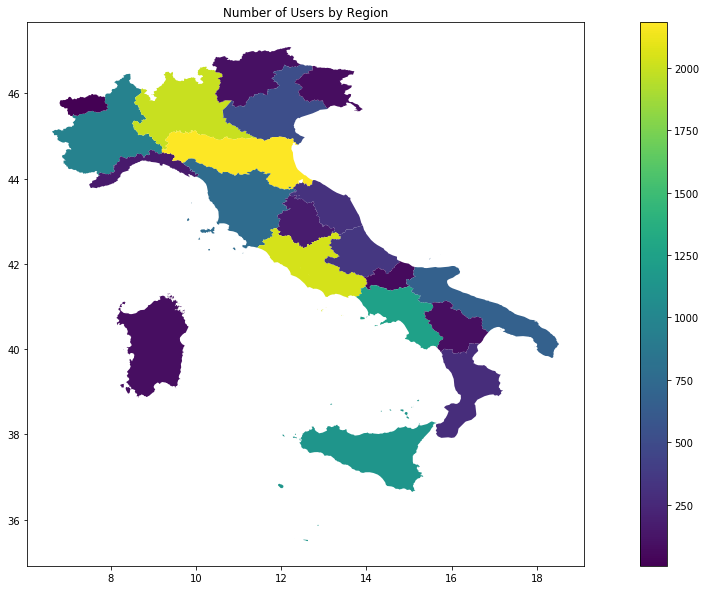

In [21]:
df2.plot(column='Count_Users',legend=True, alpha=1)
plt.title('Number of Users by Region')
fig = plt.gcf()
fig.set_size_inches(20, 10)
fig.savefig('Numer_of_Users_by_Region.png', dpi=200)
plt.show()

# Mappa 2: % di maschi per regione

In [22]:
Num_Genere=result.groupby(['REGIONE','Genere'])['User_ID'].count()
Num_Genere=Num_Genere.reset_index()
L=[]
for el in range(0,len(Num_Genere['User_ID']),2):
    Somma=Num_Genere['User_ID'][el]+Num_Genere['User_ID'][el+1]
    L.append(Somma)
    L.append(Somma)

Num_Genere['Somma']=L
Num_Genere['Ratio']=(Num_Genere['User_ID']/Num_Genere['Somma'])*100
Num_Genere

,REGIONE,Genere,User_ID,Somma,Ratio
0,ABRUZZO,F,101,346,29.190751
1,ABRUZZO,M,245,346,70.809249
2,BASILICATA,F,21,85,24.705882
3,BASILICATA,M,64,85,75.294118
4,CALABRIA,F,71,284,25.000000
5,CALABRIA,M,213,284,75.000000
6,CAMPANIA,F,356,1222,29.132570
7,CAMPANIA,M,866,1222,70.867430
8,EMILIA-ROMAGNA,F,873,2178,40.082645
9,EMILIA-ROMAGNA,M,1305,2178,59.917355


In [23]:
Num_Genere=result.groupby(['REGIONE','Genere'])['User_ID'].count()

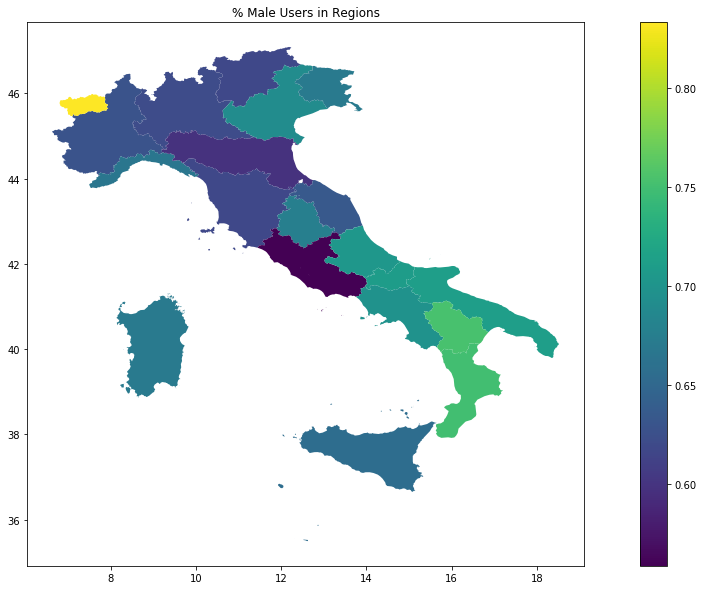

In [26]:
Num_Genere2=Num_Genere.copy()
Num_Genere2=Num_Genere2.reset_index()
Num_Genere_M=Num_Genere2[Num_Genere2['Genere']=='M']
#df2 = df2.rename(columns={'name': 'REGIONE'})

Result_M=pd.merge(df2,Num_Genere_M,how='left',on='REGIONE')
Result_M['Ratio']=Result_M['User_ID']/Result_M['Count_Users']

Result_M.plot(column='Ratio',legend=True, alpha=1)
plt.title('% Male Users in Regions')
fig = plt.gcf()
fig.set_size_inches(20, 10)
fig.savefig('Perc_Males in Region.png', dpi=200)
plt.show()

# Mappa 3: Numero di utenti totale su superficie

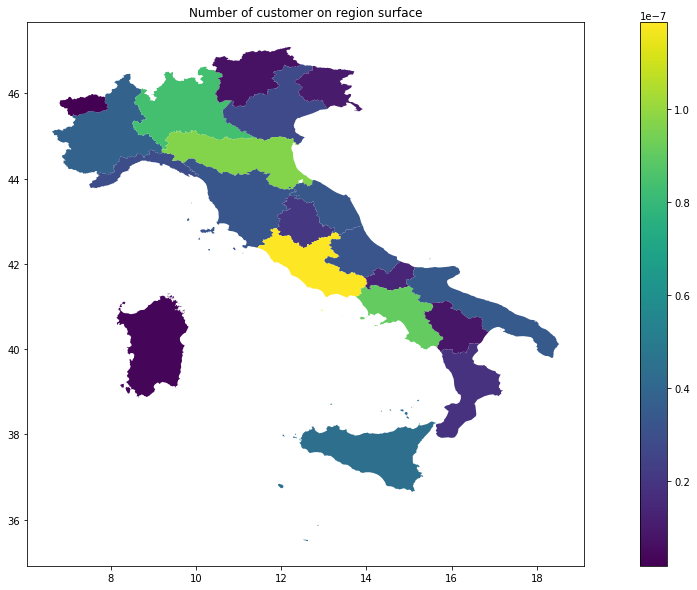

In [29]:
df2['Ratio_on_Area']=df2['Count_Users']/df2['area']
df2.plot(column='Ratio_on_Area',legend=True, alpha=1)

plt.title('Number of customer on region surface')
fig = plt.gcf()
fig.set_size_inches(20, 10)
fig.savefig('Users_on_surface.png', dpi=200)
plt.show()

# Mappa di interazione per ogni regione

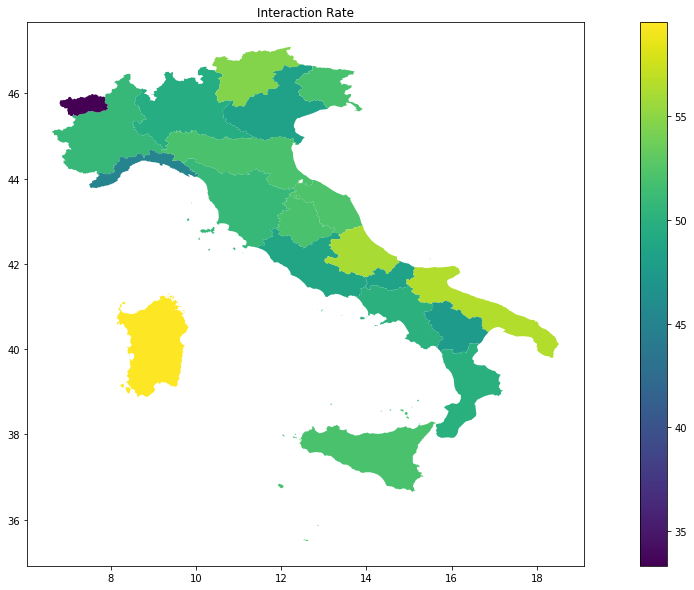

In [32]:
Int=Ottobre.groupby('REGIONE')['Risultato_contatto_Whatsapp'].mean()
Int=Int*100
Int=pd.DataFrame(Int).reset_index()
Int=Int.rename({'Risultato_contatto_Whatsapp':'Ratio_Interaction'})
Int.rename(columns={'Risultato_contatto_Whatsapp':'Ratio_Interaction'}, inplace=True)
r=pd.merge(df2,Int,on='REGIONE',how='left')
r.plot('Ratio_Interaction',legend=True)

plt.title('Interaction Rate')
fig = plt.gcf()
fig.set_size_inches(20, 10)
fig.savefig('Interaction Rate.png', dpi=200)
plt.show()

# Mappa di Conversione
Si basa su USO=Esclusivo

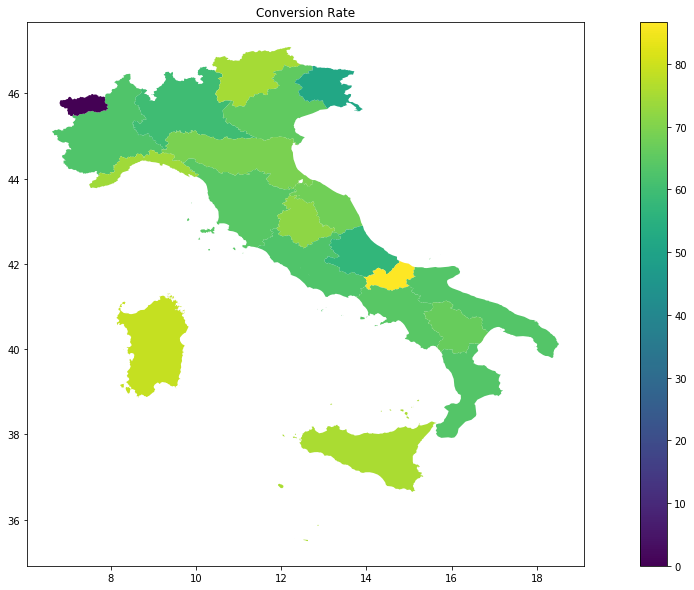

In [1146]:
#Prendo prima di tutto gli interacting users, quelli che hanno risposto al messaggio con Risultato_cont...=1
# e Utente_Convertito

Esclusivo=Ottobre[Ottobre['Tipo_di_Utilizzo']==3]
Esclusivo=Esclusivo.groupby('REGIONE').count().reset_index()
Totali=Ottobre.groupby('REGIONE').count().reset_index()
Totali=Totali[['REGIONE','Tipo_di_Utilizzo']]

Esclusivo=Esclusivo[['REGIONE','Tipo_di_Utilizzo']]

Totali.rename(columns={'Tipo_di_Utilizzo':'Totali'},inplace=True)
Esclusivo.rename(columns={'Tipo_di_Utilizzo':'Esclusivo'},inplace=True)

Conv=pd.merge(df2,Totali,on='REGIONE',how='left')
Conv=pd.merge(Conv,Esclusivo,on='REGIONE',how='left')
Conv['Ratio']=(Conv['Esclusivo']/Conv['Totali'])*100
Conv.loc[Conv['Esclusivo'].isnull(),'Ratio']=0
Conv.plot(column='Ratio',legend=True)

plt.title('Conversion Rate')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 10)
fig.savefig('Conversion Rate.png', dpi=200)
plt.show()
